<a href="https://colab.research.google.com/github/VadimFarutin/deep-unsupervised-learning/blob/hw02/hw02_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install tqdm

     |████████████████████████████████| 61kB 23.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.distributions import Normal, Uniform, MultivariateNormal
import random
import pickle
import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.nn.functional as F
from torch import autograd
import torch.optim as optim

In [3]:
SEED = 761
torch.manual_seed(SEED)

In [0]:
with open('hw2_q2.pkl', 'rb') as file:
    dataset = pickle.load(file)

In [0]:
train_data, val_data = dataset['train'].transpose(0, 3, 1, 2), dataset['test'].transpose(0, 3, 1, 2)

In [7]:
print(train_data.shape, val_data.shape)

(20000, 3, 32, 32) (6838, 3, 32, 32)


In [186]:
train = train_data[:, :, :, :]
val = val_data[:, :, :, :]
print(train.shape, val.shape)

(20000, 3, 32, 32) (6838, 3, 32, 32)


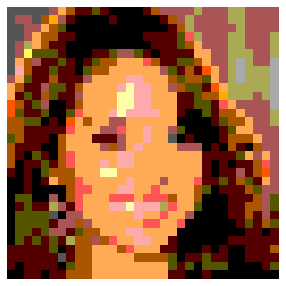

In [9]:
image = torch.FloatTensor(dataset['train']).permute(0, 3, 1, 2)[100]
image = image.permute(1, 2, 0)
fig = plt.figure(figsize=(5, 5))
plt.imshow(image[:, :, [2, 1, 0]] / 3.0)
plt.axis("off")
plt.show()

In [0]:
IMG_SIZE = 32

In [0]:
class ResBlock1(nn.Module):
    def __init__(self, num_channels):
        super(ResBlock1, self).__init__()
        layers = []
        layers.append(nn.Conv2d(num_channels, num_channels, kernel_size=1))
        layers.append(nn.BatchNorm2d(num_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(num_channels))
        self.layers = nn.Sequential(*layers)   

    def forward(self, x):
        return self.layers(x)

class ResBlock2(nn.Module):
    def __init__(self, num_channels):
        super(ResBlock2, self).__init__()
        layers = []
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(num_channels, num_channels, kernel_size=1))
        self.layers = nn.Sequential(*layers)   
        
    def forward(self, x):
        return self.layers(x)

class ResNet(nn.Module):
    def __init__(self, in_channels, res_block_channels, num_blocks):
        super(ResNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels, res_block_channels, kernel_size=3, padding=1)

        blocks1 = [ResBlock1(res_block_channels) for i in range(num_blocks)]
        self.blocks1 = torch.nn.ModuleList(blocks1)
        blocks2 = [ResBlock2(res_block_channels) for i in range(num_blocks)]
        self.blocks2 = torch.nn.ModuleList(blocks2)

        self.relu = nn.ReLU()
        self.c2 = nn.Conv2d(res_block_channels, 2 * in_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        t = self.c1(x)
        for b1, b2 in zip(self.blocks1, self.blocks2):
            r = b1(t)
            t = b2(r)
            t = self.relu(t + r)
        return self.c2(t)

In [0]:
def preprocess(x, alpha):
    a = alpha
    b = 1.0 - alpha
    y = a + b * x / 4.0

    ones = torch.ones_like(x)
    t = ones * b / 4.0
    t = t.flatten(start_dim=1)

    logdet = torch.log(t.abs())
    logdet = logdet.sum(dim=1)

    t = 1.0 / y + 1.0 / (1.0 - y)
    t = t.abs().flatten(start_dim=1)

    return logdet + torch.log(t + 1e-7).sum(dim=1)

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, mask, channels):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        self.resnet = ResNet(channels, res_block_channels=32, num_blocks=2)
    
    def forward(self, x):
        y1 = self.mask * x
        k = y1.shape[0]
        rn = self.resnet(y1)
        ls, t = torch.chunk(rn, 2, dim=1)
        ls = torch.tanh(ls)
        ls = ls.view(k, -1)
        return torch.sum(ls, dim=1)

    def latent(self, x):
        y1 = self.mask * x
        rn = self.resnet(y1)
        ls, t = torch.chunk(rn, 2, dim=1)
        y2 = (1 - self.mask) * (torch.exp(torch.tanh(ls)) * (x + t))
        return y1 + y2

    def inverse(self, y):
        x1 = self.mask * y
        rn = self.resnet(y1)
        ls, t = torch.chunk(rn, 2, dim=1)
        ls = torch.tanh(ls)
        return x1 + (1 - self.mask) * (y / torch.exp(ls) - t)

In [0]:
def build_checkerboard_mask(channels, size):
    mask1 = np.ones([1, channels, size[0], size[1]], dtype=np.bool)
    mask2 = np.ones([1, channels, size[0], size[1]], dtype=np.bool)
    odds = np.arange(1, size[0], 2)
    evens = np.arange(0, size[1], 2)
    mask1[:, :, odds, :] = False 
    mask2[:, :, :, evens] = False
    return torch.tensor(mask1 ^ mask2, dtype=torch.float32).cuda()

def build_channel_split_mask(channels, size):
    shapes = [1, channels, size[0], size[1]]
    mask = torch.zeros(shapes, dtype=torch.float32).cuda()
    inds = np.arange(0, channels // 4) * 4
    inds = np.stack((inds, inds + 1), axis=1)
    inds = inds.reshape(-1)
    mask[:, inds, :, :] = 1.0
    return mask

In [0]:
class ActivationNorm(nn.Module):
    def __init__(self, channels, size):
        super(ActivationNorm, self).__init__()
        shapes = [1, channels, size[0], size[1]]
        self.w = nn.Parameter(torch.ones(shapes))
        self.b = nn.Parameter(torch.zeros(shapes))
        
    def forward(self, x):
        w_abs = self.w.abs()
        t = torch.log(w_abs + 1e-7)
        t = t.flatten(1)
        return t.sum(dim=1)

    def latent(self, x):
        return x * self.w + self.b

    def inverse(self, y):
        return (y - self.b) / self.w

In [0]:
def inverse(y, alpha):
    x = torch.exp(y) / (torch.exp(y) + 1.0)
    return 4.0 * (x - alpha) / (1.0 - alpha)

def latent(x, alpha):
    y = torch.log(alpha + (1.0 - alpha) * x / 4.0)
    return y - torch.log(1.0 - y)

In [0]:
ALPHA = 0.05

class RealNVP(nn.Module):
    def __init__(self, channels, hw):
        super(RealNVP, self).__init__()

        def get_couplings(mask, channels, hw):
            return [AffineCoupling(mask, channels), ActivationNorm(channels, hw),
                    AffineCoupling(1 - mask, channels), ActivationNorm(channels, hw),
                    AffineCoupling(mask, channels), ActivationNorm(channels, hw)]

        mask = build_checkerboard_mask(channels, hw)
        self.layers1 = nn.Sequential(*get_couplings(mask, channels, hw),
                                        AffineCoupling(1 - mask, channels),
                                        ActivationNorm(channels, hw))

        hw = hw[0] // 2, hw[1] // 2
        channels = 4 * channels
        mask = build_channel_split_mask(channels, hw)
        self.layers2 = nn.Sequential(*get_couplings(mask, channels, hw))

        mask = build_checkerboard_mask(channels, hw)
        self.layers3 = nn.Sequential(*get_couplings(mask, channels, hw))

        hw = hw[0] // 2, hw[1] // 2
        channels = 4 * channels
        mask = build_channel_split_mask(channels, hw)
        self.layers4 = nn.Sequential(*get_couplings(mask, channels, hw))

        mask = build_checkerboard_mask(channels, hw)
        self.layers5 = nn.Sequential(*get_couplings(mask, channels, hw))

    def forward(self, x):
        suml = preprocess(x, ALPHA)
        y = latent(x, ALPHA)

        for layer in self.layers1:
            suml += layer(y)
            y = layer.latent(y)
        y = self.squeeze(y)
        for layer in self.layers2:
            suml += layer(y)
            y = layer.latent(y)
        for layer in self.layers3:
            suml += layer(y)
            y = layer.latent(y)
        y = self.squeeze(y)
        for layer in self.layers4:
            suml += layer(y)
            y = layer.latent(y)
        for layer in self.layers5:
            suml += layer(y)
            y = layer.latent(y)
        return suml
    
    def squeeze(self, x):
        b, c, h, w = x.shape
        out = F.unfold(x, (2, 2), stride=2)
        out = out.reshape(b, 4 * c, h // 2, w // 2)
        return out

    def unsqueeze(self, x):
        b, c, h, w = x.shape
        out = x.reshape(b, c, -1)
        out = F.fold(out, (2 * h, 2 * w), (2, 2), stride=2)
        return out
        
    def latent(self, x):
        y = latent(x, ALPHA)
        for layer in self.layers1:
            y = layer.latent(y)
        y = self.squeeze(y)  
        for layer in self.layers2:
            y = layer.latent(y)
        for layer in self.layers3:
            y = layer.latent(y)
        y = self.squeeze(y)    
        for layer in self.layers4:
            y = layer.latent(y)
        for layer in self.layers5:
            y = layer.latent(y)
        return self.unsqueeze(self.unsqueeze(y))

    def inverse(self, y):
        x = self.squeeze(self.squeeze(y))
        for layer in reversed(self.layers5):
            x = layer.inverse(x)
        for layer in reversed(self.layers4):
            x = layer.inverse(x)   
        x = self.unsqueeze(x)   
        for layer in reversed(self.layers3):
            x = layer.inverse(x)
        for layer in reversed(self.layers2):
            x = layer.inverse(x)          
        x = self.unsqueeze(x)        
        for layer in reversed(self.layers1):
            x = layer.inverse(x)
        return inverse(x, ALPHA)

In [0]:
def NLL_loss(z, out):
    probs = torch.distributions.Normal(0, 1).log_prob(z)
    probs = probs.flatten(start_dim=1)
    probs = probs.sum(dim=1)
    loss = - 0.5 * torch.mean(out + probs)
    return loss

In [0]:
NUM_EPOCHS = 20
LR = 1e-3
BATCH_SIZE = 128
channels, size = 3, (32, 32)
train_loader = torch.utils.data.DataLoader(torch.from_numpy(train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.from_numpy(val), batch_size=BATCH_SIZE, shuffle=False)
model = RealNVP(channels, size).float().cuda()

In [396]:
optimizer = optim.Adam(model.parameters(), lr=LR)

train_steps, train_losses = [], []
val_steps, val_losses = [], []

global_step = 0

sum_losses = 0
cnt = 0
model.eval()
for batch in val_loader:
    cnt += 1
    batch = batch.float().cuda()
    out = model(batch)
    z = model.latent(batch)
    loss = NLL_loss(z, out)
    sum_losses += loss.item()
val_steps.append(global_step)
val_losses.append(sum_losses / cnt)
        
for epoch in tqdm_notebook(range(NUM_EPOCHS)):
    model.train()
    for batch in train_loader:
        global_step += 1
        batch = batch.float().cuda()

        optimizer.zero_grad()
        out = model(batch)
        z = model.latent(batch)
        loss = NLL_loss(z, out)
        train_steps.append(global_step)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    if (epoch % 10 == 0):
      print(f"Epoch {epoch} Loss: {loss.item()}")

    sum_losses = 0
    cnt = 0
    model.eval()
    for batch in val_loader:
        cnt += 1
        batch = batch.float().cuda()
        out = model(batch)
        z = model.latent(batch)
        loss = NLL_loss(z, out)
        sum_losses += loss.item()
    val_steps.append(global_step)
    val_losses.append(sum_losses / cnt)
    
    if (epoch % 10 == 0):
        print(f"Val Loss: {val_losses[-1]}")

Epoch 0 Loss: 33197.203125
Val Loss: 5496.281005859375
Epoch 10 Loss: 636.8760375976562
Val Loss: 507.2327880859375
Epoch 20 Loss: -846.27197265625
Val Loss: -615.53955078125
Epoch 30 Loss: -2082.17333984375
Val Loss: -2087.7900390625
Epoch 40 Loss: -3140.72265625
Val Loss: -3109.195068359375
Epoch 50 Loss: -4171.3544921875
Val Loss: -4161.012451171875
Epoch 60 Loss: -5273.611328125
Val Loss: -5288.38134765625
Epoch 70 Loss: -6141.2265625
Val Loss: -6181.735595703125
Epoch 80 Loss: -6926.0908203125
Val Loss: -6985.420654296875
Epoch 90 Loss: -7627.3544921875
Val Loss: -7630.7158203125
Epoch 100 Loss: -8219.0244140625
Val Loss: -8218.67333984375
Epoch 110 Loss: -8676.599609375
Val Loss: -8668.61474609375
Epoch 120 Loss: -9080.2900390625
Val Loss: -9056.810546875
Epoch 130 Loss: -9411.3330078125
Val Loss: -9379.77001953125
Epoch 140 Loss: -9657.216796875
Val Loss: -9625.08447265625
Epoch 150 Loss: -9984.90625
Val Loss: -9863.77490234375
Epoch 160 Loss: -10166.9833984375
Val Loss: -10027.

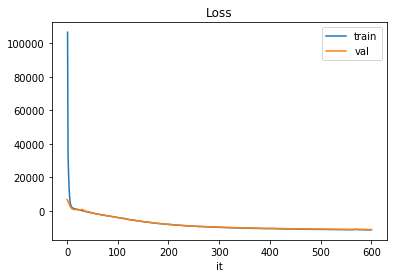

In [397]:
plt.plot(train_steps, train_losses, label='train')
plt.plot(val_steps, val_losses, label='val')
plt.title("Loss")
plt.xlabel("it")
plt.legend()
plt.show()

In [215]:
print(f"Final val set performance: {val_loss_values[-1]}")

Final val set performance: -12740.9111328125


In [0]:
PATH = "model-ckpt.pth"
torch.save(model.state_dict(), PATH)

In [0]:
model2 = RealNVP(channels, size).float().cuda()
model2.load_state_dict(torch.load(PATH))
summary = model2.eval()

In [0]:
def get_random_inds(k=10):
  train_sz = len(train)
  all_inds = np.arange(train_sz)
  np.random.shuffle(all_inds)
  r_inds = all_inds[:k]
  return list(r_inds)

In [0]:
NUM_ROWS = 5
INTERPOLATION_LEN = 6
H, W = 6, 6
ind, colors, height, width = 0, 1, 2, 3

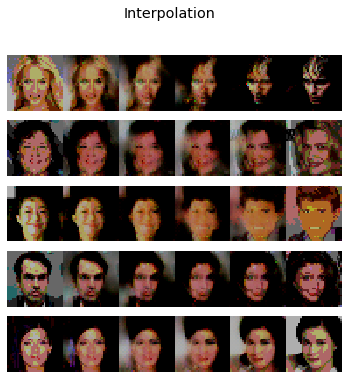

In [287]:
inds = get_random_inds(2 * NUM_ROWS)

lefts = [train[i] for i in inds[: NUM_ROWS]]
lefts = torch.tensor(lefts).cuda()

rights = [train[i] for i in inds[NUM_ROWS:]]
rights = torch.tensor(rights).cuda()

fig, ax = plt.subplots(NUM_ROWS, INTERPOLATION_LEN)
fig.suptitle("Interpolation", fontsize="x-large")
fig.set_figheight(H)
fig.set_figwidth(W)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(NUM_ROWS):
    left = model.latent(lefts[i].unsqueeze(0))
    right = model.latent(rights[i].unsqueeze(0))

    for j in range(INTERPOLATION_LEN):
        A = 1 - j / (INTERPOLATION_LEN - 1)
        B = j / (INTERPOLATION_LEN - 1)
        img = model.inverse(A * left + B * right)
        img = img.permute(ind, height, width, colors)[0]
        img = img.cpu().detach().numpy()
        img = img[:, :, [2, 1, 0]] # BGR to RGB
        img /= 2
        img = np.clip(img, 0, 1)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")
plt.show()

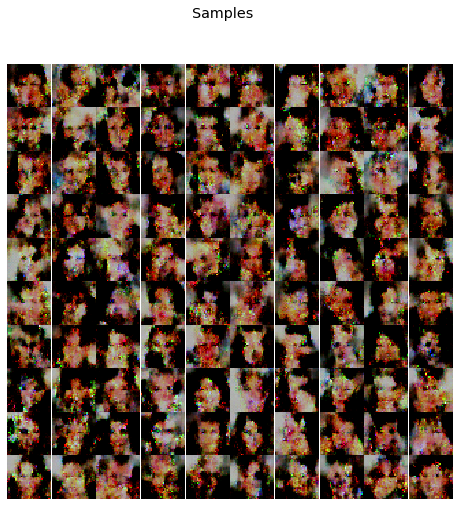

In [307]:
NUM_SAMPLES = 100
H, W = 8, 8

z = Normal(0, 1).rsample((NUM_SAMPLES * 3 * IMG_SIZE * IMG_SIZE, 1)).cuda()
z = z.view(NUM_SAMPLES, 3, IMG_SIZE, IMG_SIZE)

imgs = model.inverse(z)
imgs = imgs.permute(ind, height, width, colors)
imgs = imgs.cpu().detach().numpy()

imgs = imgs[:, :, :, [2, 1, 0]] # BGR to RGB
imgs /= 2
imgs = np.clip(imgs, 0, 1)

SIDE_SIZE = int(np.sqrt(NUM_SAMPLES))

fig, axarr = plt.subplots(SIDE_SIZE, SIDE_SIZE)
fig.suptitle("Samples", fontsize="x-large")
fig.set_figheight(H)
fig.set_figwidth(W)
plt.subplots_adjust(wspace=0, hspace=0)

for k, img in enumerate(imgs):
    i, j = k // SIDE_SIZE, k % SIDE_SIZE
    axarr[i, j].imshow(img)
    axarr[i, j].axis('off')

plt.show()